In [1]:
import tweepy
import json
from pymongo import MongoClient
from collections import Counter
from collections.abc import MutableMapping
import logging
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import community
import seaborn as sns
from fastprogress import master_bar, progress_bar
import time
import re

#Logger
logging.basicConfig(filename='Anàlisi-GetBotStats.log', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logging.getLogger().addHandler(ch)

In [2]:
##############
# PARAMETERS #
##############

client = MongoClient(username='XXX', password='XXX')

DatabaseName = "Streaming"
CollectionName = "Users"

db = client[DatabaseName]

In [3]:
#########################
# BOTSCORE DISTRIBUTION #
#########################

def load_users(user_collection):
    """Extracts the ObjectID and botscore of users
    
    Keyword arguments:
    user_collection -- MongoDB Users' Collection
    """
    pipeline = [
                {
                    '$match': {
                        'botometer_score': {
                            '$exists': True
                        },
                    }
                }, {
                    '$project': {
                        '_id': True, 
                        'botometer_score.raw_scores.universal.overall': True
                    }
                }
            ]
    print("Query", end=" ")
    users = user_collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    users = list(users)
    print("OK; Total users:", len(users))
    return users

def flatten(d, parent_key='', sep='_'):
    """Formats MongoDB results
    
    Keyword arguments:
    d -- dictionary with key and uncleaned values
    parent_key --
    sep --
    """
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

users = load_users(db[CollectionName])
users = [flatten(u) for u in users]
df_users = pd.DataFrame(users)
df_users.columns = ['uid', 'universal']
df_users = df_users[df_users['universal'].notna()]
print("OK; Cleaning Error Botscores. Total users:", len(df_users))

p75 = np.percentile(df_users.universal,75)
p95 = np.percentile(df_users.universal,95)
print("Limits:", p75, p95)

print('Humans:',len(df_users[df_users.universal<=p75]))
print('Bots:',len(df_users[df_users.universal>=p95]))

Query OK; List OK; Total users: 631762
OK; Cleaning Error Botscores. Total users: 552675
Limits: 0.35 0.78
Humans: 415170
Bots: 28710
CPU times: user 16.3 s, sys: 1min 47s, total: 2min 3s
Wall time: 2min 33s


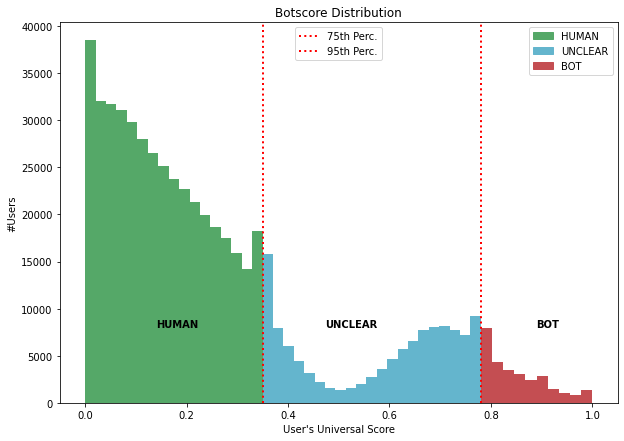

In [4]:
######################################
# PLOT BOTSCORE DISTRIBUTION (NICE!) #
######################################

import matplotlib.patches as mpatches

# color palette
colors = ["#C44E52", #red
          "#55A868", #green
          "#FFC400", #yellow
          "#4C72B0", #blue
          "#DD8452", #orange
          "#8172B3", #purple
          "#64B5CD", #cyan
          "#937860", #brown
          "#8C8C8C", #gray
         ]

# we round the botscore to discretize
df_users.universal = np.round(df_users.universal,2)
x = df_users.universal

# make equal binning through the range, you can adapt the bin size here
counts, bins = np.histogram(x, bins=100)

prs = [75,95]
ps = np.percentile(a=df_users.universal, q=prs)

# here we do the filtering and split the observations based on your color code
x1 = x[(x <= ps[0])]
x2 = x[((x >= ps[0]) & (x <= ps[1]))]
x3 = x[(x >= ps[1])]

# finally, do the plot
f, ax = plt.subplots(figsize=(10,7))
ax.hist(x1, bins=int(ps[0]*50), color="#55A868")
ax.hist(x2, bins=int((ps[1]-ps[0])*50), color="#64B5CD")
ax.hist(x3, bins=int((1-ps[1])*50), color="#C44E52")
ax.set(xlabel="User\'s Universal Score", ylabel="#Users", title="Botscore Distribution")

for pr,p in zip(prs,ps):
    label = str(pr) + "th Perc."
    plt.axvline(p, linewidth = 2, label=label, linestyle='dotted', color='red')

# common legend
first_legend = plt.legend(loc="upper center")
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)


#LABELS
plt.text(ps[0]/2.5, 8000, "HUMAN", weight="bold")
plt.text((ps[1]-ps[0])*1.1, 8000, "UNCLEAR", weight="bold")
plt.text(ps[1]+(1-ps[1])/2, 8000, "BOT", weight="bold")

# Create another legend for the second line.
green_patch = mpatches.Patch(color='#55A868', label='HUMAN')
cyan_patch = mpatches.Patch(color='#64B5CD', label='UNCLEAR')
red_patch = mpatches.Patch(color='#C44E52', label='BOT')
plt.legend(handles=[green_patch, cyan_patch, red_patch], loc="upper right")

#plt.savefig(GRAPHICS_DIR + "Botscores-distribution" + FIG_EXTENSION, bbox_inches = "tight")
plt.savefig("Botscores-distribution-" + CollectionName + ".jpg", bbox_inches = "tight")

plt.show()